In [ ]:
# import all necessary libraries needed
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
from tqdm import tqdm

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models.phrases import Phraser
from gensim.models import Phrases, CoherenceModel

# spacy for lemmatization
import spacy
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
speeches = pd.read_csv('../data/speeches.csv')
print('the shape of speeches  : ', speeches.shape)
speeches.head()

the shape of speeches  :  (156, 4)


,Unnamed: 0,Date,Title,Speech
0,0,"March 1, 2021",Address by Minister for Foreign Affairs Hon. M...,\n\nAddress by Minister for Foreign Affairs Ho...
1,1,"February 23, 2021","Statement by Hon. Mr. Pradeep Kumar Gyawali, M...",\n\nStatement by Hon. Mr. Pradeep Kumar Gyawal...
2,2,"January 21, 2021",Opening Statement by Hon. Mr. Pradeep Kumar Gy...,\n\nOpening Statement by Hon. Mr. Pradeep Kuma...
3,3,"January 21, 2021","Statement by Hon. Mr. Pradeep Kumar Gyawali, M...",\n\nStatement by Hon. Mr. Pradeep Kumar Gyawal...
4,4,"January 15, 2021",Talks Given by Minister for Foreign Affairs of...,\n\nTalks Given by Minister for Foreign Affair...


In [ ]:
data = speeches.copy()
data = data.drop('Unnamed: 0', axis=1)
data['Date'] =pd.to_datetime(data.Date)
data.head()

,Date,Title,Speech
0,2021-03-01,Address by Minister for Foreign Affairs Hon. M...,\n\nAddress by Minister for Foreign Affairs Ho...
1,2021-02-23,"Statement by Hon. Mr. Pradeep Kumar Gyawali, M...",\n\nStatement by Hon. Mr. Pradeep Kumar Gyawal...
2,2021-01-21,Opening Statement by Hon. Mr. Pradeep Kumar Gy...,\n\nOpening Statement by Hon. Mr. Pradeep Kuma...
3,2021-01-21,"Statement by Hon. Mr. Pradeep Kumar Gyawali, M...",\n\nStatement by Hon. Mr. Pradeep Kumar Gyawal...
4,2021-01-15,Talks Given by Minister for Foreign Affairs of...,\n\nTalks Given by Minister for Foreign Affair...


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

stop_words = set(stopwords.words('english'))
# a function to preprocess the data
def Preprocessing(text):
    text = text.lower()
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])  
    text = re.sub(r"[^a-zA-Z]"," ",text)  
    tokens = [w for w in text.split() if not w in stop_words]
    long_words = [i for i in tokens if len(i)>=3]
    return long_words

def ngram(doc, data_words):
  ng2 = Phrases(data_words,min_count=5, threshold=30)
  ng3 = Phrases(ng2[data_words],threshold=30)
  ng2_model = Phraser(ng2)
  ng3_model = Phraser(ng2)
  return ng3_model[ng2_model[doc]]

def lemmatization(text):
    nlp = spacy.load('en', disable=['parser', 'ner'])
    allowed_postags=['NOUN', 'ADJ','VERB','ADV']
    #newString = nlp(text)
    newString = nlp(' '.join(text))
    #text_out = []
    return [word.lemma_ for word in newString if word.pos_ in allowed_postags]

In [ ]:
def dictionary_corpus(data_words):
  id2word = corpora.Dictionary(data_words)              # create dictionary
  texts = data_words                                     # create corpus
  corpus = [id2word.doc2bow(text) for text in texts]     # Text Dcoument Frequency
  return id2word, texts, corpus


# finding optimal topic numbers
def optimum_topics(dictionary, corpus, texts, start=2, end=20, step=2):
  model_list = []
  coherence_values = []
  start, end, step = 2, 20, 2
  for k in tqdm(range(start, end, step)):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5,
                                           passes=4,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_value = coherence_model.get_coherence()
    model_list.append(model)
    coherence_values.append(coherence_value)
  return model_list, coherence_values


def execute_model(data_words, id2word, corpus):
  model_list, coherence_values = optimum_topics(dictionary=id2word, corpus=corpus, texts=data_words, start=2, end=20, step=2)
  print('\n')
  start, end, step = 2, 20, 2
  x = range(start, end, step)
  for k, cv in zip(x, coherence_values):
    print(k,"number of topics has coherence value : ", round(cv,4))    
  return model_list, coherence_values

In [ ]:
## function to make dataframe for each topics 
def topics_term_prob(optimal_model,topics):
  topics_df = []
  for i in range(len(topics)):
    df = pd.DataFrame(optimal_model.show_topic(i), columns=['term','prob']).set_index('term')
    df['Topic'] = "topics_"+str(i)
    topics_df.append(df)
  return topics_df

In [ ]:
data['cleaned_speech'] = data['Speech'].apply(lambda x: Preprocessing(x))
data['cleaned_speech'] = data['cleaned_speech'].apply(lambda x: ngram(x, list(data.cleaned_speech)))
data['cleaned_speech'] = data['cleaned_speech'].apply(lambda x: lemmatization(x))

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
data_words = list(data.cleaned_speech)

In [1]:
#print(data_words)

In [ ]:
id2word, texts,corpus = dictionary_corpus(data_words)
model_list, coherence_list = execute_model(data_words, id2word, corpus)

100%|██████████| 9/9 [00:51<00:00,  5.70s/it]



2 number of topics has coherence value :  0.3498
4 number of topics has coherence value :  0.4259
6 number of topics has coherence value :  0.4247
8 number of topics has coherence value :  0.4123
10 number of topics has coherence value :  0.3832
12 number of topics has coherence value :  0.4267
14 number of topics has coherence value :  0.3983
16 number of topics has coherence value :  0.4231
18 number of topics has coherence value :  0.4426


In [ ]:
optimal_model = model_list[2]            # select best model
print('Topics generated by model:')
print('-------------------------------------------------------------\n')
topics = optimal_model.print_topics()
topics 

Topics generated by model:
-------------------------------------------------------------



[(0,
  '0.018*"optimism" + 0.016*"gratitude" + 0.016*"education" + 0.015*"disadvantaged" + 0.014*"spend" + 0.012*"divert" + 0.010*"assembly" + 0.009*"infuse" + 0.009*"woman" + 0.008*"struggle"'),
 (1,
  '0.015*"relation" + 0.014*"development" + 0.013*"investment" + 0.013*"nepal" + 0.012*"economic" + 0.010*"connectivity" + 0.010*"cooperation" + 0.010*"country" + 0.009*"project" + 0.009*"trade"'),
 (2,
  '0.026*"right" + 0.021*"international" + 0.020*"peace" + 0.020*"human_right" + 0.013*"principle" + 0.012*"woman" + 0.011*"constitute" + 0.010*"guarantee" + 0.010*"commitment" + 0.010*"inclusive"'),
 (3,
  '0.020*"people" + 0.014*"country" + 0.013*"must" + 0.012*"development" + 0.011*"make" + 0.011*"well" + 0.010*"world" + 0.009*"need" + 0.007*"challenge" + 0.007*"great"'),
 (4,
  '0.012*"embark" + 0.010*"environmental" + 0.009*"synergy" + 0.008*"administrative" + 0.008*"graduation" + 0.007*"food" + 0.005*"arrival" + 0.005*"globally" + 0.005*"scientific" + 0.005*"retreat"'),
 (5,
  '0.018

In [ ]:
#save obtained optimal_model
optimal_model.save('LDA.model')

In [ ]:
topics_df_list = topics_term_prob(optimal_model,topics)

In [ ]:
# save above topics dataframes as csv file
dir = '../extracted_topics/topics_df/'
for i in range(len(topics_df_list)):
  topics_df_list[i].to_csv(dir+"topic_"+str(i)+".csv")

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.171260  0.118870       1        1  36.839902
1     -0.166992 -0.164009       2        1  26.456495
5     -0.177401  0.006669       3        1  23.964636
2      0.136948  0.254523       4        1   9.047424
0      0.208849 -0.102735       5        1   2.218274
4      0.169856 -0.113318       6        1   1.473270, topic_info=                Term        Freq       Total Category  logprob  loglift
455            right  222.000000  222.000000  Default  30.0000  30.0000
282    international  327.000000  327.000000  Default  29.0000  29.0000
372            peace  228.000000  228.000000  Default  28.0000  28.0000
284       investment  274.000000  274.000000  Default  27.0000  27.0000
981             must  364.000000  364.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
862             food    7.918770   11.035619   Topic6  -4.9853   3.8858
921           inputs    3.325433    4.370149   Topic6  -5.8529   3.9445
3131     interactive    3.312060    4.391977   Topic6  -5.8570   3.9355
809          disease    3.557640    6.557835   Topic6  -5.7854   3.6061
2474  sustainability    3.818955    8.320264   Topic6  -5.7146   3.4390

[342 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
702       1  0.902098      action
702       4  0.093320      action
704       5  0.905156  adaptation
11        1  0.649824     address
11        2  0.010566     address
...     ...       ...         ...
560       1  0.920964       world
560       2  0.033128       world
560       3  0.016564       world
560       4  0.029815       world
3345      6  0.901874       worth

[492 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 6, 3, 1, 5])

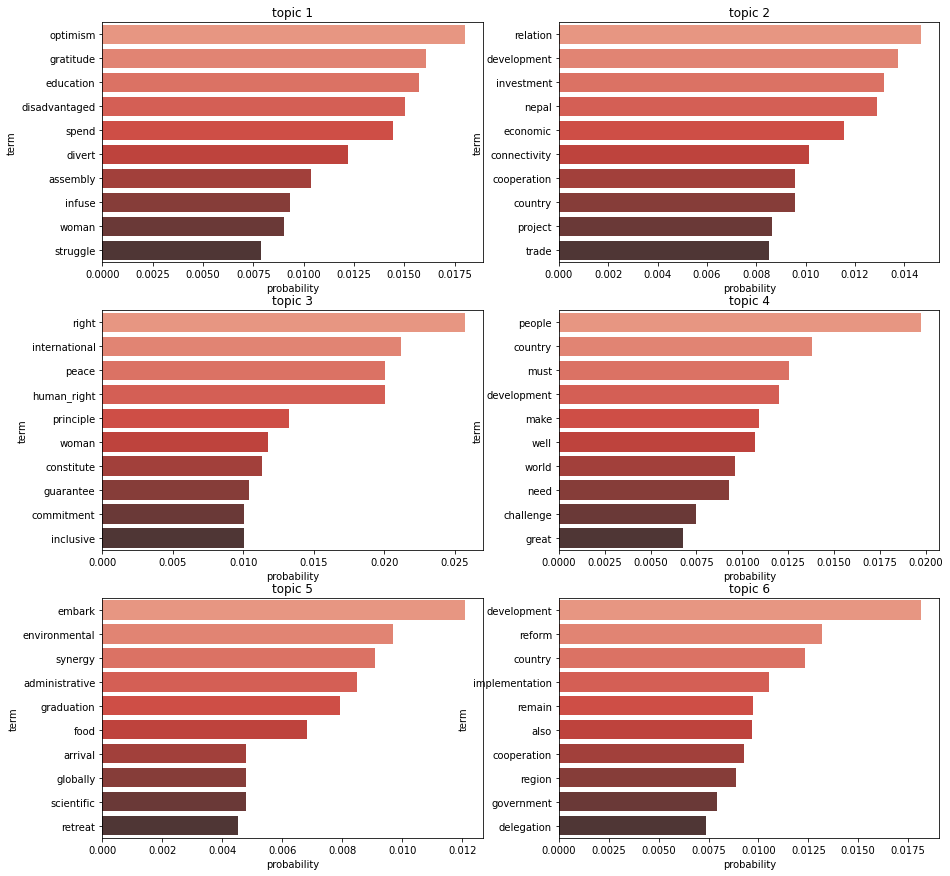

In [ ]:
## barplot showing importance of each keywords in topics 
fiz = plt.figure(figsize=(15,15))
if len(topics)%2 == 0:
  n_rows = int(len(topics)/2)
else:
  n_rows = int((len(topics)+1)/2)
for i in range(len(topics)):
    df = pd.DataFrame(optimal_model.show_topic(i), columns=['term','prob']).set_index('term')
    # df=df.sort_values('prob')
    plt.subplot(n_rows,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
plt.show()

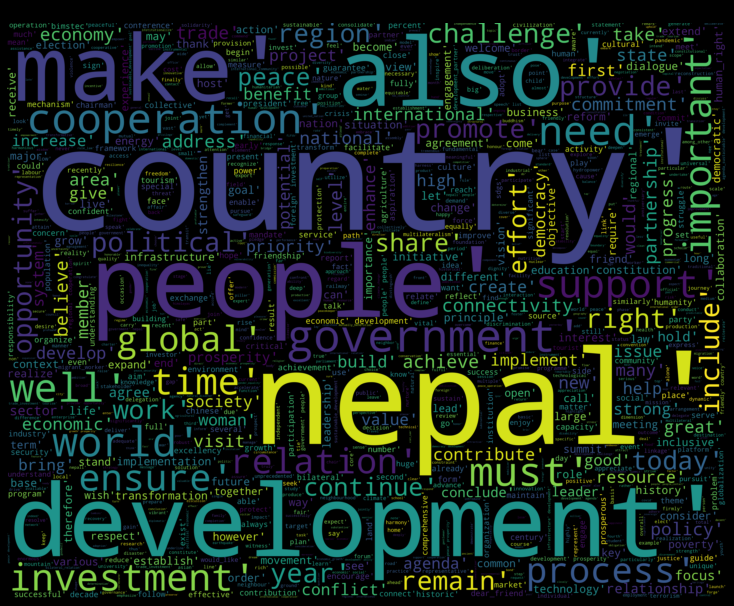

In [ ]:
## Word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
spchs = data.cleaned_speech.values
wordcloud = WordCloud(width = 5000,
                      height = 4000,
                      background_color = 'black',
                      max_words=1000).generate(str(spchs))
fig = plt.figure(figsize = (10, 14),
                 facecolor = 'k',
                 edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Speeches Word Cloud')
plt.savefig("../Graphs/word_cloud.png")
plt.show()